In [1]:
from DataLoader import loadCsiData
from CSIFase import get_Phase, get_phase_diff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = "../Data/Apneia5_1-Mariana-Intel 5300-Normal-Sentado_costas-FFZ-_1m-Intel 5300-26_09_2022-15_49-99_94Hz-25R-90bpm.txt"
phase_diff_unwraped = pd.DataFrame(get_phase_diff(path))

Quantidade de pacotes:  12000
Shape das fases: (12000, 171)


In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Sem média móvel

In [4]:
trace = go.Scatter(x = list(range(12000)),
                   y = phase_diff_unwraped[0],
                   mode = 'markers')
data = [trace]
py.iplot(data)

# Realizando média móvel

In [6]:
trace = go.Scatter(x = list(range(12000)),
                   y = phase_diff_unwraped[0].rolling(10).mean(),
                   mode = 'markers')
data = [trace]
py.iplot(data)

## Plotando todas as subports

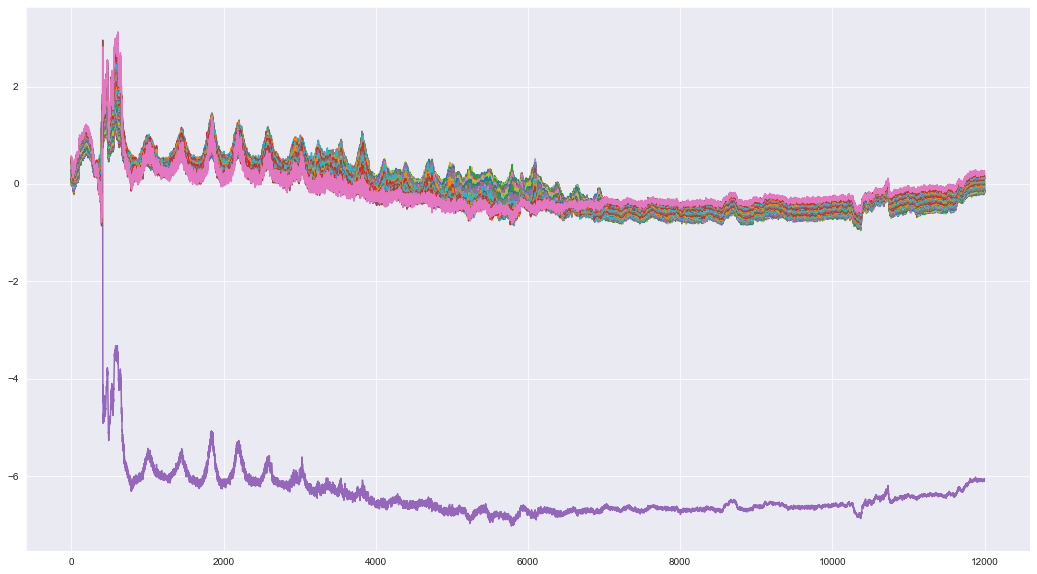

In [34]:
plt.figure(figsize=(18,10))
for i in phase_diff_unwraped.columns:
    plt.plot(phase_diff_unwraped[i])

plt.savefig()

> O que fazer? Tirar uma média das subportadoras ou não? Temos que averiguar como está nas outras capturas...

> Já sei, vai tudo virar dado de treino!!

# Construindo uma IA (1st attempt)

Como features, para uma ROI, temos:
- O desvio padrão
- A variância
- Vamos tentar!

VAmos definir o tamanho arbitrário para a ROI, em que ela terá 500 pacotes (já que uma respiração lenta tem cerca de 300 pacotes, vamos extrapolar um pouco para garantir que uma muito lenta seja detectada) e vamos ajustando por tentativa e erro.

Não parece fazer sentido atualizar a janela a cada novo pacote que chega, pois apenas um pacote não traz muita informação. Portanto, cerca de 100 pacotes (1 segundo de captura a 100 hz) parece trazer mais informações.

In [11]:
# vamos criar uma função deslizante que retorna os pacotes de um intervalo K entre os pontos A e B (início-fim)

def desliza_sobre_dados(data, k=500, ini=0, fim=9000):
    assert len(data.shape) == 1, f"Data must be a Series or unidimensional array! Got {data.shape} instead."
    ROIs = []
    data = np.array(data)
    for idx in range(ini, fim, 100):
        if len(data[idx:idx+k]) == k and (idx != 0 and idx != 9000) and (fim - idx >= k):
            ROIs.append(data[idx:idx+k])

    return ROIs

In [12]:
# passando um dataframe e obtendo um array com N slices de 500 pkts
len(desliza_sobre_dados(phase_diff_unwraped[0][:,0]))

85

## Criando os dados de treino

In [2]:
import os

In [3]:
paths = os.listdir("F:/Dados CSI/")
phase_diff_unwraped = []
for path in paths:
    phase_diff_unwraped.append(get_phase_diff("F:/Dados CSI/"+path))

Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  11583
Shape das fases: (11583, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das fases: (12000, 171)
Quantidade de pacotes:  12000
Shape das 

In [4]:
len(phase_diff_unwraped)

30

> Temos 30 amostras

In [8]:
phase_diff_unwraped[0].shape

(12000, 57)

> Cada amostra com 12000 pacotes e 57 subportadoras. Sendo cada amostra a diferença de fase entre duas antenas.

> Todos os dados são de mesma relevância, isto é, não vamos diferenciar a quantidade de respirações nem a velocidade ou quem foi. Pegaremos todos os experimentos e trataremos como sendo respiração e apneia.

In [13]:
# criando um sistema para percorrer cada amostra e cada subportadora, pegando os primeiros 9000 pkts para respiracao e os últimos 3000 pkts para apneia.

treino_resp = []
treino_apneia = []
for amostra in phase_diff_unwraped:
    # cada amostra é um np array
    for subport in range(amostra.shape[1]):
        # temos cada subportadora da amostra nesse ponto
        # vamos dividir em pequenos clusters de 500
        treino_resp.append(desliza_sobre_dados(amostra[:, subport]))
        treino_apneia.append(desliza_sobre_dados(amostra[:, subport], ini=9000, fim=12000))
treino_resp = np.array(treino_resp)
treino_apneia = np.array(treino_apneia)

C:\Users\alexv\AppData\Local\Temp\ipykernel_28844\3570962631.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  treino_apneia = np.array(treino_apneia)


In [8]:
len(treino_resp)

1710

> Se temos 30 amostras, cada uma com 57 subs, temos que ter 30 * 57 (1710) itens na lista de treino, sendo cada item um array com 89 segmentos de tamanho 500 pkts.

In [9]:
treino_resp = np.array(treino_resp)

In [10]:
treino_resp.shape

(1710, 89, 500)

In [15]:
len(treino_apneia)

1710

In [17]:
treino_apneia[0].shape

[array([2.60856193, 2.50901315, 2.46701896, 2.43743933, 2.55940186,
        2.58435084, 2.5646899 , 2.43148204, 2.43029635, 2.55065573,
        2.5451913 , 2.55065573, 2.40368687, 2.47388384, 2.48696992,
        2.51234695, 2.53804378, 2.42081704, 2.48279891, 2.50174372,
        2.55643601, 2.5749565 , 2.41868391, 2.43873349, 2.52064894,
        2.57037148, 2.50332269, 2.43544125, 2.45999584, 2.55065573,
        2.60323879, 2.59484947, 2.46927558, 2.42160593, 2.47504259,
        2.5520782 , 2.57868577, 2.41951095, 2.49170771, 2.57293616,
        2.55905889, 2.52363528, 2.46411443, 2.49713546, 2.55905889,
        2.5446498 , 2.57176077, 2.46425718, 2.44955236, 2.51363561,
        2.49985202, 2.55065573, 2.38244896, 2.44610013, 2.55503526,
        2.59874696, 2.58465623, 2.42203223, 2.37526151, 2.51090395,
        2.56185974, 2.54210893, 2.42510599, 2.46425718, 2.49515722,
        2.53341606, 2.6042955 , 2.43965872, 2.44485756, 2.5012773 ,
        2.53286401, 2.56133148, 2.41403032, 2.41

AttributeError: 'list' object has no attribute 'shape'